# Map human scRNA-seq kidney on mouse Visium kidney.

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
fld = os.path.join(home, 'kidney_dataset')
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'human_kidney_map.h5ad')
ad_sc = sc.read_h5ad(path)
# Convert mouse genes to human convention
ad_sc.var.index = ad_sc.var.index.str.upper()
ad_sc.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'visium_mouse_kidney_filtered.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sc.var_names_make_unique()

# filter obs in ROI
mask = ad_sp.obs.in_ROI == True
ad_sp.obs = ad_sp.obs[mask]

# there are no empty voxel
sums = np.sum(ad_sp.X, axis=1).A1
assert np.sum(sums == 0) == 0

# take list of HV genes
assert ad_sc.var.highly_variable.all()
hv_genes = ad_sc.var.index.values

# Convert mouse genes to human convention
ad_sp.var.index = ad_sp.var.index.str.upper()

# Only shared genes between visium and sn
mask = ad_sp.var.index.isin(hv_genes)
ad_sp = ad_sp[:, mask]
ad_sp

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 1438 × 1654
    obs: 'in_ROI', 'frame_x', 'frame_y', 'x_fu', 'y_fu', 'x_hi', 'y_hi', 'x_lo', 'y_lo'
    var: 'gene_ids'

In [5]:
'Annotate marker genes on Visium'
mask = ad_sc.var.marker
marker_genes = ad_sc.var[mask].index.values
ad_sp.var['marker'] = ad_sp.var.index.isin(marker_genes)
ad_sp.var['marker'].sum()

Trying to set attribute `.var` of view, copying.


781

In [6]:
'Restrict ad_sc on shared genes and reindex as ad_sp'
hv_genes = ad_sp.var.index.values
mask = ad_sc.var.index.isin(hv_genes)
ad_sc = ad_sc[:, mask]
ad_sc.var = ad_sc.var.reindex(ad_sp.var.index)

In [7]:
assert ad_sc.var.index.equals(ad_sp.var.index)

***
## Feature selection

In [8]:
# 'Compute gene sparsity across datasets'
# sparsity_sc = np.sum((ad_sc.X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp.X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On HV genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [9]:
# 'Filter genes'
# # take out genes sparse in sc and not in Visium
# mask_1 = sparsity_sc > 0.9
# mask_2 = sparsity_sp < 0.5
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = mask

# # take out super sparse genes
# mask_1 = sparsity_sc > 0.97
# mask_2 = sparsity_sp > 0.97
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

# # take out genes sparse in Visium and not in sc
# mask_1 = sparsity_sc < 0.5
# mask_2 = sparsity_sp > 0.6
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

In [10]:
# sparsity_sc = np.sum((ad_sc[:, total_mask].X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp[:, total_mask].X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On ' + str(total_mask.sum()) + ' genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5); 

In [11]:
ad_sc_fl = ad_sc
ad_sp_fl = ad_sp

known_markers = [
    'CYRAB', 'NAPSA', 'NDUFB8', 'COXBA', 'HBB-BS', 'SERPINA1F'
]

[gene in list(ad_sc_fl.var.index.values) for gene in known_markers]

[False, True, False, False, False, False]

In [12]:
# sparsity_sc = np.sum(ad_sc_fl.X, axis=0) / np.sum(ad_sc.X)
# sparsity_sp = np.sum(ad_sp_fl.X.toarray(), axis=0) / np.sum(ad_sp.X)
# # plt.xscale('log')
# # plt.yscale('log')
# # plt.xlabel('Sparsity (scRNAseq)');
# # plt.ylabel('Sparsity (Visium)');
# # plt.title('On HV genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [13]:
# mask = ad_sc.var.marker
# ad_sc_marker = ad_sc[:, mask]
# mask = ad_sp.var.marker
# ad_sp_marker = ad_sp[:, mask]
# assert ad_sp_marker.var.index.equals(ad_sc_marker.var.index)

In [14]:
# sparsity_sc = np.sum((ad_sc_marker.X == 0), axis=0) / ad_sc_marker.n_obs
# sparsity_sp = np.sum((ad_sp_marker.X.toarray() == 0), axis=0) / ad_sp_marker.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On marker genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

***

In [15]:
'Allocate matrices and select device'
S = np.array(ad_sc_fl.X, dtype='float32')
G = np.array(ad_sp_fl.X.toarray(), dtype='float32')
d = np.zeros(ad_sp_fl.n_obs)
device = torch.device('cuda:0')  # for gpu

In [16]:
'Define Tangram hyperparameters'
## TODO pars not in manuscript
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
#     'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
#     'lambda_f_reg' : ,  # regularizer: filter values are Boolean
}
learning_rate = 0.1
num_epochs = 6000

- Is `MapperConstrained` the same as `Mapper` w/o filter? NO: il filtro c'e' sempre negli altri terms della loss
-  Forse chiamarlo `MapperWithFilter`

In [17]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
mapper = mapping.mapping_optimizer.Mapper(
    S=S, G=G, d=d, device=device, 
    **hyperparm, 
)

#### TODO
- Save history of loss terms in mapping object.
- Plot entropy regularizer term.
- If I add an incorrect hyperparamter, spit out an error

In [18]:
'Train Tangram'
# The output are the various terms in the loss function (see manuscript).
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (ie the hyperaparameter)
output = mapper.train(learning_rate=learning_rate, num_epochs=num_epochs)

nan 0.4132448434829712 0.07453332841396332
nan 0.7047351002693176 0.16774678230285645
nan 0.7060408592224121 0.18659137189388275
nan 0.7060676217079163 0.19216668605804443
nan 0.7058820128440857 0.19474191963672638
nan 0.7057262659072876 0.19626614451408386
nan 0.7056503295898438 0.19726912677288055
nan 0.7056044936180115 0.19782127439975739
nan 0.7053996324539185 0.1986491084098816
nan 0.7050818204879761 0.1994747817516327
nan 0.7048771381378174 0.2001611739397049
nan 0.7046872973442078 0.20071280002593994
nan 0.704436182975769 0.20129942893981934
nan 0.7042477130889893 0.20181745290756226
nan 0.7041488289833069 0.20214784145355225
nan 0.7041330933570862 0.2023082822561264
nan 0.7040413022041321 0.20255552232265472
nan 0.7039006352424622 0.20289380848407745
nan 0.7038237452507019 0.20310457050800323
nan 0.7037658095359802 0.20323655009269714
nan 0.703559398651123 0.203592449426651
nan 0.7034603357315063 0.2038288116455078
nan 0.703437328338623 0.20396332442760468
nan 0.703420042991638

**Tommaso** I get 0.702 and 0.207 for cosine similarities.

In [21]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(ad_sc_fl.obs['subsampling.label'])
prob_assign = mapping.utils.transfer_annotations_prob(output, df_classes)
prob_assign.head()

,Myofibroblast,Podocyte,LOH,Monocyte/macrophage,Dendritic cell,TAL,NK cell,Arteriolar EC,Peritubular EC,Glomerular EC,...,Myocyte,aIC,CD8+ T cell,Proximal tubule (ALDOB-high),DCT,B cell,bIC,CD4+ T cell,PC,Dividing
0,0.000105,6.851543e-08,0.000473,0.000003,8.477582e-08,2.518587e-07,0.000278,0.000128,2.332850e-07,0.000859,...,5.796633e-08,0.001470,0.000156,0.000287,2.846047e-04,2.546867e-04,8.981417e-08,1.028036e-04,0.000446,3.225838e-08
1,0.506719,5.232932e-02,0.391568,0.229050,1.934580e-01,7.220975e-01,0.273973,0.224431,5.225017e-01,0.293878,...,3.970026e-02,0.258624,0.889480,1.748526,1.084605e-07,5.243926e-07,4.473605e-02,2.420966e-01,2.477418,1.503018e-07
2,0.489972,2.284706e-01,0.731940,1.101155,5.844253e-01,1.356127e+00,0.891945,0.405821,1.091112e+00,0.569799,...,9.732612e-02,0.709637,0.913285,6.211245,9.714873e-02,1.565078e-01,1.823005e-01,1.753219e+00,0.484033,1.396393e-01
3,0.102656,5.935338e-02,0.117348,0.050158,1.452924e-02,3.759490e-02,0.116240,0.100784,8.604467e-02,0.032625,...,2.449421e-07,0.354673,0.028651,0.234699,1.491644e-07,1.586260e-02,5.214159e-02,7.965355e-07,1.035549,8.331376e-03
4,0.593775,2.591294e-01,2.522916,1.041979,8.686607e-01,1.815241e+00,1.086121,0.322902,1.200423e+00,0.746031,...,1.572033e-01,3.038931,2.417075,7.654853,3.733054e-01,3.035289e-01,1.104000e-01,3.929076e+00,0.217430,8.824876e-03


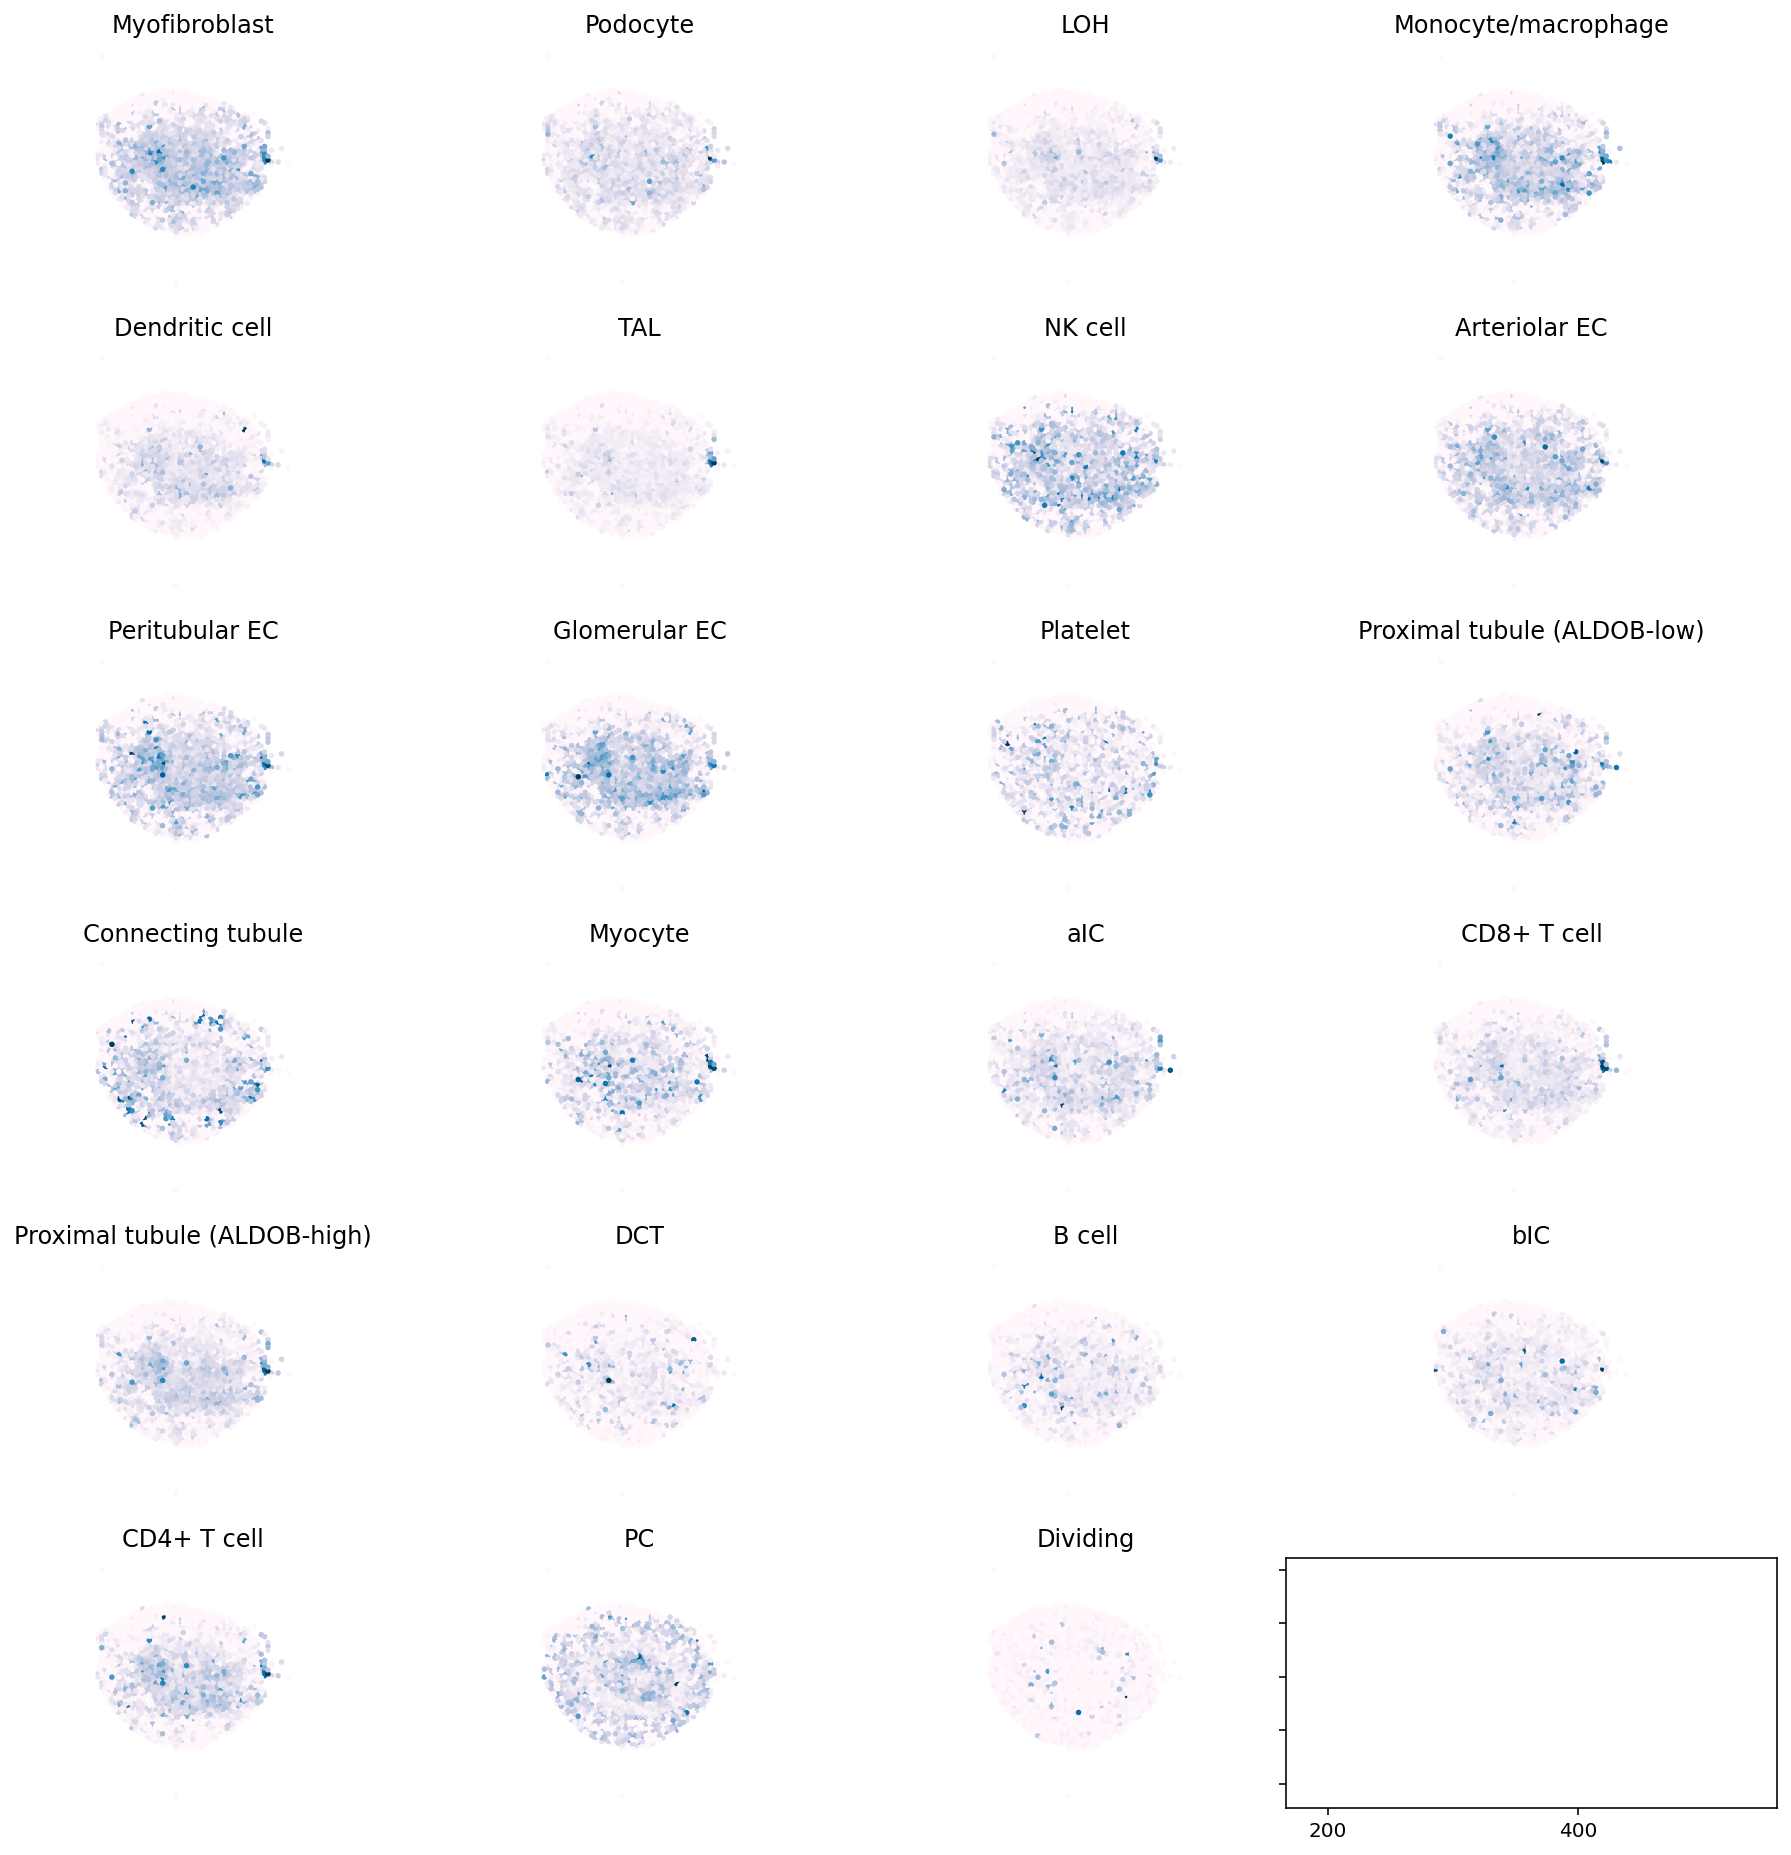

In [22]:
cell_types = list(ad_sc_fl.obs['subsampling.label'].unique())

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(13, 13), sharex=True, sharey=True)
for ax, ct in zip(axs.flatten(), cell_types):
    ax.scatter(x=ad_sp_fl.obs.x_lo, 
               y=ad_sp_fl.obs.y_lo, 
               c=prob_assign[ct], 
               s=3, 
               cmap='PuBu');
    ax.set_title(ct)
    ax.set_aspect(1)
    ax.axis('off');
plt.tight_layout()